
** References**

*   https://github.com/12dmodel/deep_motion_mag
*   https://github.com/ZhengPeng7/motion_magnification_learning-based
*   https://pytorch.org/tutorials/beginner/former_torchies/nnft_tutorial.html
*   https://towardsdatascience.com/residual-network-implementing-resnet-a7da63c7b278












In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
%cd '/content/drive/Othercomputers/My_PC/ML/Project/DetectMicroscopicMotion/code/deep_motion_mag-master/Using_Pytorch/References'

/content/drive/Othercomputers/My_PC/ML/Project/DetectMicroscopicMotion/code/deep_motion_mag-master/Using_Pytorch/References


In [4]:
import os
import sys
import time
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.backends.cudnn as cudnn

In [5]:
#define Building blocks

def numpy2cuda(array):
    tensor = torch.from_numpy(np.asarray(array)).float().cuda()
    #tensor = torch.from_numpy(np.asarray(array)).float()
    return tensor

#https://pytorch.org/tutorials/beginner/former_torchies/nnft_tutorial.html
class Conv2D(nn.Module):
    def __init__(
            self, in_channels, out_channels, kernel_size, stride,
            padding=0, dilation=1, activation='relu'
    ):
        super(Conv2D, self).__init__()
        self.padding = padding
        if self.padding:
            self.pad = nn.ReflectionPad2d(padding)
        self.conv2d = nn.Conv2d(
            in_channels, out_channels, kernel_size, stride,
            dilation=dilation, bias=None
        )
        self.activation = activation
        if activation == 'relu':
            self.activation = nn.ReLU()

    def forward(self, x):
        if self.padding:
            x = self.pad(x)
        x = self.conv2d(x)
        if self.activation:
            x = self.activation(x)
        return x

#https://towardsdatascience.com/residual-network-implementing-resnet-a7da63c7b278
class ResidualBlock(nn.Module):
  def __init__(self, in_channels, out_channels,dim_intermediate=32, ks=3, s=1 ):
        super(ResidualBlock,self).__init__()
        p = (ks - 1) // 2
        self.L_1 = Conv2D(in_channels, dim_intermediate, ks, s, p, activation='relu')
        self.L_2 = Conv2D(dim_intermediate, out_channels, ks, s, p, activation=None)
     
    
  def forward(self, x):
    residual = x
    x = self.L_1(x)
    x = self.L_2(x)
    x += residual
        
    return x
        
def _repeat_blocks(block, dim_in, dim_out, num_blocks, dim_intermediate=32, ks=3, s=1):
    blocks = []
    for idx_block in range(num_blocks):
        if idx_block == 0:
            blocks.append(block(dim_in, dim_out, dim_intermediate=dim_intermediate, ks=ks, s=s))
        else:
            blocks.append(block(dim_out, dim_out, dim_intermediate=dim_intermediate, ks=ks, s=s))
    return nn.Sequential(*blocks)    

#Loss -- Need to evaluate
def criterion_mag(y, batch_M, texture_AC, texture_BM, motion_BC, criterion):
    # One thing deserves mentioning is that the amplified frames given in the dataset are actually perturbed Y(Y'), which I used M to represent.
    loss_y = criterion(y, batch_M)
    loss_texture_AC = criterion(*texture_AC)
    loss_texture_BM = criterion(*texture_BM)
    loss_motion_BC = criterion(*motion_BC)
    return loss_y, loss_texture_AC, loss_texture_BM, loss_motion_BC

**Encoder Block**

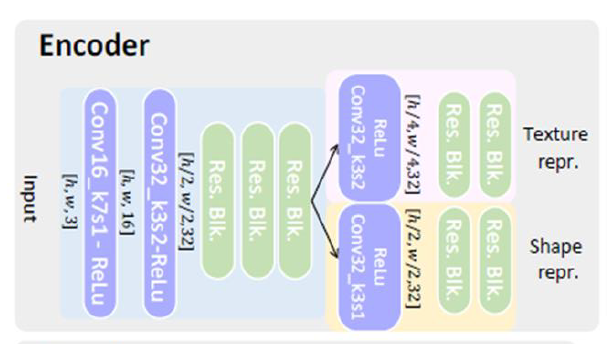

In [6]:
#Define Encoder
class Encoder(nn.Module):
  def __init__(self):
    super(Encoder, self).__init__()
    self.L_1 = Conv2D(3, 16, 7, 1, 3, activation='relu')
    self.L_2 = Conv2D(16, 32, 3, 2, 1, activation='relu')

    self.L_3_5 = _repeat_blocks(ResidualBlock, 32, 32, 3)

    # texture representation
    self.L1_6 = Conv2D( 32, 32, 3, 2, 1,activation='relu' )
    self.L1_7_8 = _repeat_blocks(ResidualBlock, 32, 32, 2)

    # motion representation
    self.L2_6 = Conv2D(32, 32, 3, 1, 1, activation='relu')
    self.L2_7_8 = _repeat_blocks(ResidualBlock, 32, 32, 2)

  def forward(self, x):
    x = self.L_1(x)
    x = self.L_2(x)
    x = self.L_3_5(x)

    texture = self.L1_6(x)
    texture = self.L1_7_8(texture)
  
    motion = self.L2_6(x)
    motion = self.L2_7_8(motion)
  
    return texture, motion




**Decode Block**

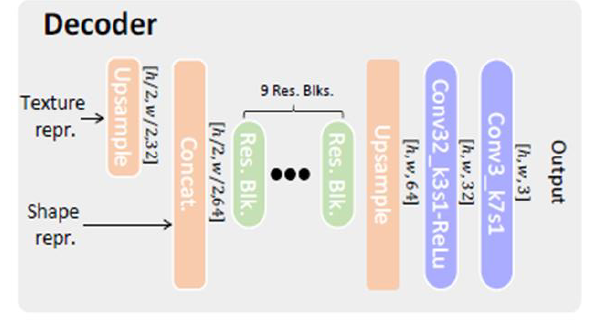

In [7]:
#Define Decoder
class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
                
        self.texture_up = nn.UpsamplingNearest2d(scale_factor=2)
        
        self.resblks = _repeat_blocks(ResidualBlock, 64, 64, 9, dim_intermediate=64)
        self.up = nn.UpsamplingNearest2d(scale_factor=2)
        self.L_1 = Conv2D(64, 32, 3, 1, 1, activation='relu')
        self.L_2 = Conv2D(32, 3, 7, 1, 3, activation=None)

    def forward(self, texture, motion):
        texture = self.texture_up(texture)
        if motion.shape != texture.shape:
            texture = nn.functional.interpolate(texture, size=motion.shape[-2:])
        x = torch.cat([texture, motion], 1)

        x = self.resblks(x)

        x = self.up(x)
        x = self.L_1(x)
        x = self.L_2(x)

        return x



**Manipulator Block**

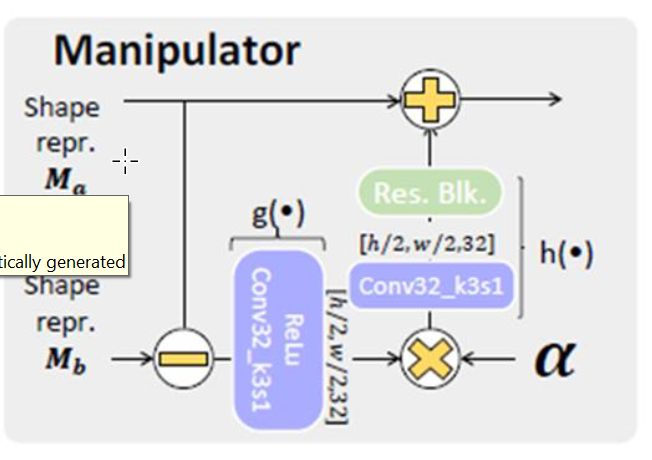

In [8]:
#Define Manipulator
class Manipulator(nn.Module):
    def __init__(self):
        super(Manipulator, self).__init__()
        self.g = Conv2D(32, 32, 3, 1, 1, activation='relu')
        self.h_conv = Conv2D(32, 32, 3, 1, 1, activation=None)
        self.h_resblk = ResidualBlock(32, 32)
    #A and B are interchanged compared to diagram
    def forward(self, motion_A, motion_B, amp_factor):
        motion = motion_B - motion_A
        motion_delta = self.g(motion) * amp_factor
        motion_delta = self.h_conv(motion_delta)
        motion_delta = self.h_resblk(motion_delta)
        motion_mag = motion_B + motion_delta
        return motion_mag




**Model**

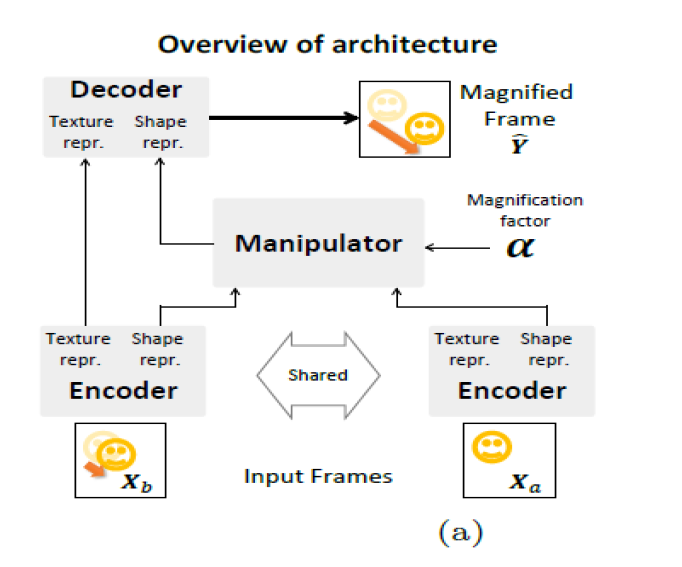

In [9]:
class MagNet(nn.Module):
    def __init__(self):
        super(MagNet, self).__init__()
        self.encoder = Encoder()
        self.manipulator = Manipulator()
        self.decoder = Decoder()

    def forward(self, batch_A, batch_B, batch_C, batch_M, amp_factor):
        
            texture_A, motion_A = self.encoder(batch_A)
            texture_B, motion_B = self.encoder(batch_B)
            texture_C, motion_C = self.encoder(batch_C)
            texture_M, motion_M = self.encoder(batch_M)
            motion_mag = self.manipulator(motion_A, motion_B, amp_factor)
            y_hat = self.decoder(texture_B, motion_mag)
            #need to evaluate if we need this code here
            texture_AC = [texture_A, texture_C]
            motion_BC = [motion_B, motion_C]
            texture_BM = [texture_B, texture_M]
            return y_hat, texture_AC, texture_BM, motion_BC
            #to be removed
      


In [ ]:
#import torch
#torch.cuda.empty_cache()
#torch.cuda.memory_summary(device=None, abbreviated=False)
#export PYTORCH_CUDA_ALLOC_CONF=max_split_size_mb:1280


SyntaxError: ignored

In [10]:
import glob
import cv2
from skimage.io import imread
import torch

def unit_postprocessing(unit, vid_size=None):
    unit = unit.squeeze()
    unit = unit.cpu().detach().numpy()
    unit = np.clip(unit, -1, 1)
    unit = np.round((np.transpose(unit, (1, 2, 0)) + 1.0) * 127.5).astype(np.uint8)
    if unit.shape[:2][::-1] != vid_size and vid_size is not None:
        unit = cv2.resize(unit, vid_size, interpolation=cv2.INTER_CUBIC)
    return unit



#def numpy2cuda(array):
    #tensor = torch.from_numpy(np.asarray(array)).float().cuda()
 #   tensor = torch.from_numpy(np.asarray(array)).float()
 #   return tensor


def gen(Pointer):
        batch_A = []
        batch_B = []
        batch_C = []
        batch_M = []
       
        batch_amp = []
        
        #files = glob.glob(path_A)

        counter = 0
        print("***") 
        print(path_A)
        #print(files)
        for idx_data in range(batch_size):
          filename= path_A + str(Pointer).zfill(6) + ".png"
          Pointer =  Pointer +1
          print(filename)
        
          unit_A = cv2.cvtColor(imread(filename).astype(np.uint8), cv2.COLOR_RGB2BGR)
          unit_B = cv2.cvtColor(imread(filename.replace('frameA', 'frameB') ).astype(np.uint8), cv2.COLOR_RGB2BGR)
          unit_C = cv2.cvtColor(imread(filename.replace('frameA', 'frameC') ).astype(np.uint8), cv2.COLOR_RGB2BGR)
          unit_M = cv2.cvtColor(imread(filename.replace('frameA', 'amplified') ).astype(np.uint8), cv2.COLOR_RGB2BGR)
          
          unit_A = np.transpose(unit_A, (2, 0, 1))
          unit_B = np.transpose(unit_B, (2, 0, 1))
          unit_C = np.transpose(unit_C, (2, 0, 1))
          unit_M = np.transpose(unit_M, (2, 0, 1))
          
          #print(unit_A)  

          batch_A.append(unit_A)
          batch_B.append(unit_B)
          batch_C.append(unit_C)
          batch_M.append(unit_M)
          unit_amp = amplifications[Pointer]
          batch_amp.append(unit_amp)


        batch_A = numpy2cuda(batch_A)
        batch_C = numpy2cuda(batch_C)
        batch_M = numpy2cuda(batch_M)
        batch_B = numpy2cuda(batch_B)
        batch_amp = numpy2cuda(batch_amp).reshape(batch_size, 1, 1, 1)
        
        return batch_A, batch_B, batch_C, batch_M, batch_amp, Pointer


def criterion_mag(y, batch_M, texture_AC, texture_BM, motion_BC, criterion):
    # One thing deserves mentioning is that the amplified frames given in the dataset are actually perturbed Y(Y'), which I used M to represent.
    loss_y = criterion(y, batch_M)
    loss_texture_AC = criterion(*texture_AC)
    loss_texture_BM = criterion(*texture_BM)
    loss_motion_BC = criterion(*motion_BC)
    return loss_y, loss_texture_AC, loss_texture_BM, loss_motion_BC         



In [11]:
#config
epochs = 12
batch_size = 20
Pointer= 0
path = "/content/drive/Othercomputers/My_PC/ML/Project/DetectMicroscopicMotion/dataset/extracted/train"
#path_A = path+ "/frameA/10k/"
path_A = "/content/drive/Othercomputers/My_PC/ML/Project/DetectMicroscopicMotion/dataset/extracted/train/frameA/10K/"
#path_B = path+ "/frameB/10k/"
#path_C = path+ "/frameC/10k/"
#path_M = path+ "/frameM/10k/"
amplifications = np.loadtxt('/content/drive/Othercomputers/My_PC/ML/Project/DetectMicroscopicMotion/dataset/extracted/train/train_mf.txt')

In [12]:
#Main block to be executed
magnet = MagNet().cuda()
if torch.cuda.device_count() > 1:
    magnet = nn.DataParallel(magnet)
#magnet = MagNet()
criterion = nn.L1Loss().cuda()
#criterion = nn.L1Loss()
optimizer = optim.Adam(magnet.parameters(), lr=1e-4, betas=(0.9, 0.999))


loss_dict = {}
for epoch in range(1, epochs+1):
  losses, losses_y, losses_texture_AC, losses_texture_BM, losses_motion_BC = [], [], [], [], []
  # Data Loading
  optimizer.zero_grad()
  batch_A, batch_B, batch_C, batch_M, batch_amp, Pointer = gen(Pointer)
  y_hat, texture_AC, texture_BM, motion_BC = magnet(batch_A, batch_B, batch_C, batch_M, batch_amp)
  loss_y, loss_texture_AC, loss_texture_BM, loss_motion_BC = criterion_mag(y_hat, batch_M, texture_AC, texture_BM, motion_BC, criterion)
  loss = loss_y + (loss_texture_AC + loss_texture_BM + loss_motion_BC) * 0.1
  loss_dict[epoch] = loss
  loss.backward()
  optimizer.step()



***
/content/drive/Othercomputers/My_PC/ML/Project/DetectMicroscopicMotion/dataset/extracted/train/frameA/10K/
/content/drive/Othercomputers/My_PC/ML/Project/DetectMicroscopicMotion/dataset/extracted/train/frameA/10K/000000.png
/content/drive/Othercomputers/My_PC/ML/Project/DetectMicroscopicMotion/dataset/extracted/train/frameA/10K/000001.png
/content/drive/Othercomputers/My_PC/ML/Project/DetectMicroscopicMotion/dataset/extracted/train/frameA/10K/000002.png
/content/drive/Othercomputers/My_PC/ML/Project/DetectMicroscopicMotion/dataset/extracted/train/frameA/10K/000003.png
/content/drive/Othercomputers/My_PC/ML/Project/DetectMicroscopicMotion/dataset/extracted/train/frameA/10K/000004.png
/content/drive/Othercomputers/My_PC/ML/Project/DetectMicroscopicMotion/dataset/extracted/train/frameA/10K/000005.png
/content/drive/Othercomputers/My_PC/ML/Project/DetectMicroscopicMotion/dataset/extracted/train/frameA/10K/000006.png
/content/drive/Othercomputers/My_PC/ML/Project/DetectMicroscopicMotion

RuntimeError: ignored

In [22]:
loss_dict

{1: tensor(108.5521, device='cuda:0', grad_fn=<AddBackward0>),
 2: tensor(102.4348, device='cuda:0', grad_fn=<AddBackward0>),
 3: tensor(98.3617, device='cuda:0', grad_fn=<AddBackward0>),
 4: tensor(102.3196, device='cuda:0', grad_fn=<AddBackward0>),
 5: tensor(89.7376, device='cuda:0', grad_fn=<AddBackward0>),
 6: tensor(82.8060, device='cuda:0', grad_fn=<AddBackward0>),
 7: tensor(84.2834, device='cuda:0', grad_fn=<AddBackward0>),
 8: tensor(64.6716, device='cuda:0', grad_fn=<AddBackward0>),
 9: tensor(51.8040, device='cuda:0', grad_fn=<AddBackward0>),
 10: tensor(49.6334, device='cuda:0', grad_fn=<AddBackward0>),
 11: tensor(71.3611, device='cuda:0', grad_fn=<AddBackward0>),
 12: tensor(62.4321, device='cuda:0', grad_fn=<AddBackward0>)}

In [13]:
#count Parameters  

# https://stackoverflow.com/questions/49201236/check-the-total-number-of-parameters-in-a-pytorch-model


#pytorch_total_params = sum(p.numel() for p in magnet.parameters() if p.requires_grad)
#pytorch_total_params

from prettytable import PrettyTable

def count_parameters(model):
    table = PrettyTable(["Modules", "Parameters"])
    total_params = 0
    for name, parameter in model.named_parameters():
        if not parameter.requires_grad: continue
        params = parameter.numel()
        table.add_row([name, params])
        total_params+=params
    print(table)
    print(f"Total Trainable Params: {total_params}")
    return total_params
    
count_parameters(magnet)


+----------------------------------------+------------+
|                Modules                 | Parameters |
+----------------------------------------+------------+
|       encoder.L_1.conv2d.weight        |    2352    |
|       encoder.L_2.conv2d.weight        |    4608    |
|   encoder.L_3_5.0.L_1.conv2d.weight    |    9216    |
|   encoder.L_3_5.0.L_2.conv2d.weight    |    9216    |
|   encoder.L_3_5.1.L_1.conv2d.weight    |    9216    |
|   encoder.L_3_5.1.L_2.conv2d.weight    |    9216    |
|   encoder.L_3_5.2.L_1.conv2d.weight    |    9216    |
|   encoder.L_3_5.2.L_2.conv2d.weight    |    9216    |
|       encoder.L1_6.conv2d.weight       |    9216    |
|   encoder.L1_7_8.0.L_1.conv2d.weight   |    9216    |
|   encoder.L1_7_8.0.L_2.conv2d.weight   |    9216    |
|   encoder.L1_7_8.1.L_1.conv2d.weight   |    9216    |
|   encoder.L1_7_8.1.L_2.conv2d.weight   |    9216    |
|       encoder.L2_6.conv2d.weight       |    9216    |
|   encoder.L2_7_8.0.L_1.conv2d.weight   |    92

877968